In this notebook we'll quantify the differences between the raw text data of the paraphrases and the prompt generations.

In [55]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Loading data

Previous auxiliar functions

In [1]:
def choose_device(device):
    if device==0:
        return 'cuda:0'
    elif device==1:
        return 'cuda:1'
    elif device ==-1:
        return 'cpu'
    else:
        raise Exception('Return 0 or 1 for GPUs or -1 for CPU')

def load_device(cuda_id):
    cuda = choose_device(cuda_id)
    device = torch.device(cuda if torch.cuda.is_available() else "cpu")
    return device

def load_AutoModel(model_id,cuda_id):
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side = "left") 
    tokenizer.pad_token_id = tokenizer.eos_token_id #required in llama because no padding token is defined
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    device = load_device(cuda_id)
    model = model.to(device)

    return tokenizer, model, device, terminators

def load_prompts(prompt_type, prompt_topic):
    #load prompt from .txt
    if prompt_type == 'completion':
        with open('../prompts-comp/'+prompt_topic+'.txt') as file:
            prompt = file.read()
    elif prompt_type == 'generation':
        with open('../prompts-gen/'+prompt_topic+'.txt') as file:
            prompt = file.read()
        prompt = json.loads(prompt, strict=False)
    return prompt

def prepare_llama_prompt(tokenizer, prompt, device):
    text = tokenizer.apply_chat_template(prompt, add_generation_prompt=True, tokenize=False) 
    inputs = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    inputs = {key: val.to(device) for key, val in inputs.items()} #move inputs into cuda
    return inputs

### Load prompt-based generations and decode them

Auxiliar function for this notebook

In [26]:
def load_tokens_and_decode(prompt_type, prompt_topic, tokenizer, device):

    prompt = load_prompts(prompt_type, prompt_topic)
    checkpoint_path = "../checkpoints/ids_" + prompt_topic + ".pt"
    generations = torch.load(checkpoint_path)
    model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
    tensor_size_prompt = model_inputs['input_ids'].shape[1]

    return tokenizer.batch_decode(generations[:,tensor_size_prompt:])

In [ ]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer, model, device, terminators = load_AutoModel(model_id, cuda_id=0)

In [28]:
prague_list = load_tokens_and_decode(prompt_type="generation",prompt_topic="prague",tokenizer=tokenizer, device=device)
viktor_list = load_tokens_and_decode(prompt_type="generation",prompt_topic="viktor",tokenizer=tokenizer, device=device)
sciencefic_list = load_tokens_and_decode(prompt_type="generation",prompt_topic="sciencefic",tokenizer=tokenizer, device=device)

### Load paraphrased generations

In [30]:
def remove_clause_numbers(story: str) -> str:
    #d+ - one or more digits, \. - dot, \s* - newlines and spaces
    cleaned = re.sub(r"\d+\.\s*", "", story) 
    #remove additional spaces
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

In [32]:
dir_path = "../rephrasings"

first_stories = {}
second_stories = {}

for i in range(1, 4):
    first_file_path = f"story{i}.json"
    second_file_path = f"{i}_high_temp_costly.json"

    first_path = os.path.join(dir_path,first_file_path)
    second_path = os.path.join(dir_path,second_file_path)

    with open(first_path, "r", encoding="utf-8") as f:
        first_stories[i] = json.load(f)
    with open(second_path, "r", encoding="utf-8") as f:
        second_stories[i] = json.load(f)

In [42]:
para1_list_1 = [remove_clause_numbers(story) for story in first_stories[1]]
para1_list_2 = [remove_clause_numbers(story) for story in first_stories[2]]
para1_list_3 = [remove_clause_numbers(story) for story in first_stories[3]]

para2_list_1 = [remove_clause_numbers(story) for story in second_stories[1]]
para2_list_2 = [remove_clause_numbers(story) for story in second_stories[2]]
para2_list_3 = [remove_clause_numbers(story) for story in second_stories[3]]

## Sentence length tests

In [ ]:
viktor_len = [len(story.split()) for story in viktor_list]
prague_len = [len(story.split()) for story in prague_list]
sciencefic_len = [len(story.split()) for story in sciencefic_list]

para1_list_1_len = [len(story.split()) for story in para1_list_1]
para1_list_2_len = [len(story.split()) for story in para1_list_2]
para1_list_3_len = [len(story.split()) for story in para1_list_3]

para2_list_1_len = [len(story.split()) for story in para2_list_1]
para2_list_2_len = [len(story.split()) for story in para2_list_2]
para2_list_3_len = [len(story.split()) for story in para2_list_3]

batch_lengths = [viktor_len,prague_len,sciencefic_len,
                 para1_list_1_len, para1_list_2_len,para1_list_3_len,
                 para2_list_1_len,para2_list_2_len,para2_list_3_len]


labels = [
    "Viktor", "Prague", "Science Fiction",
    "Para1 List 1", "Para1 List 2", "Para1 List 3",
    "Para2 List 1", "Para2 List 2", "Para2 List 3"
]

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c",
    "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22"
]

#### Which group of stories tend to be longer?

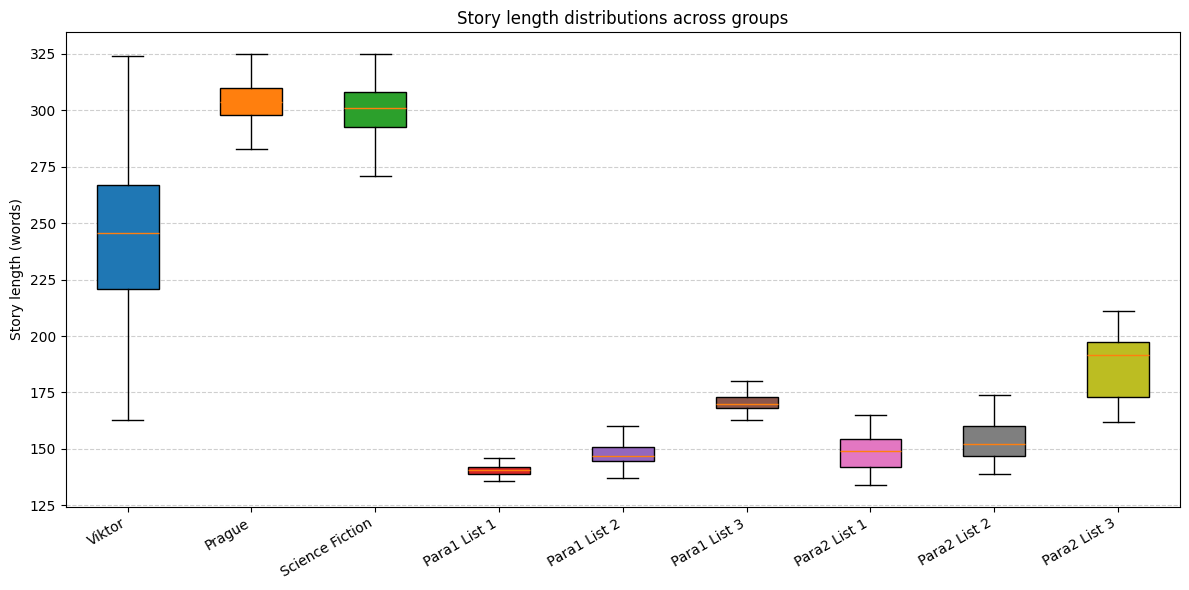

In [ ]:
#boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(batch_lengths, patch_artist=True, tick_labels=labels, showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel("Story length (words)")
plt.title("Story length distributions across groups")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


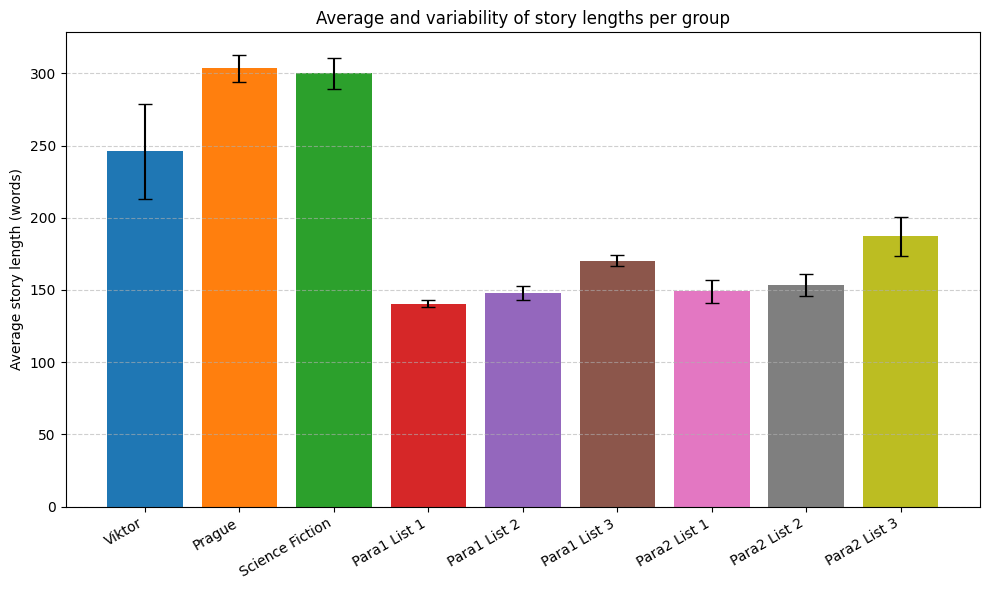

In [59]:
means = [np.mean(lens) for lens in batch_lengths]
stds = [np.std(lens) for lens in batch_lengths]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, means, yerr=stds, color=colors, capsize=5)
plt.ylabel("Average story length (words)")
plt.title("Average and variability of story lengths per group")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### Checking the spread per batch

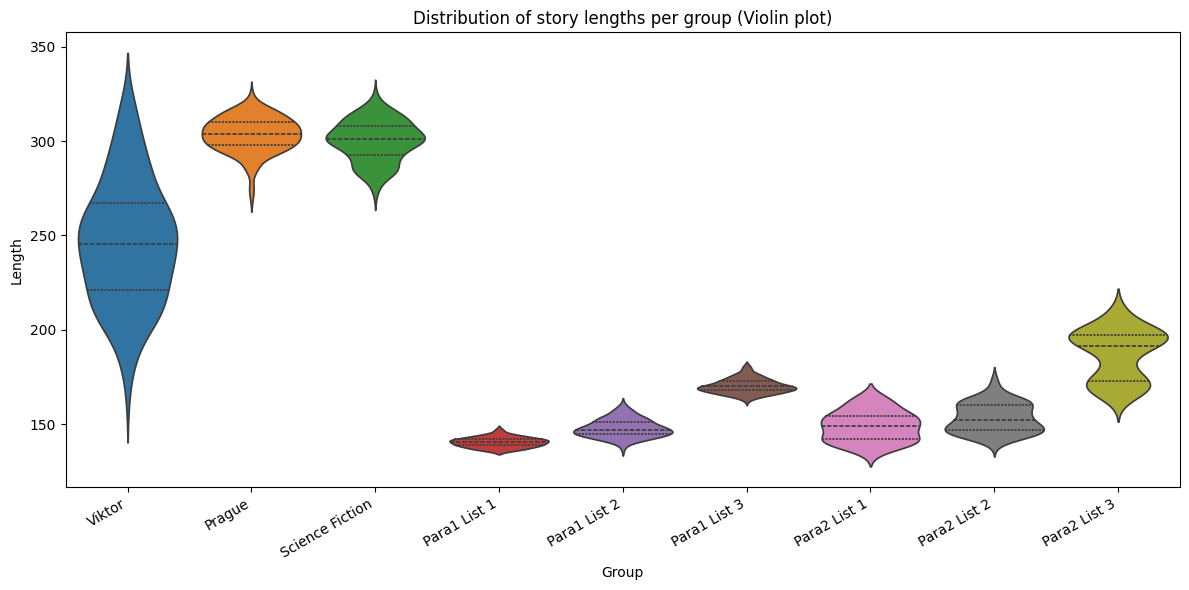

In [60]:
#violin plot - density view
data = []
for label, lens in zip(labels, batch_lengths):
    for l in lens:
        data.append({"Group": label, "Length": l})
df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df,
    x="Group",
    y="Length",
    hue="Group",          # explicitly set hue
    palette=colors,       # your color palette
    inner="quartile",
    legend=False          # disables redundant legend
)
plt.title("Distribution of story lengths per group (Violin plot)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


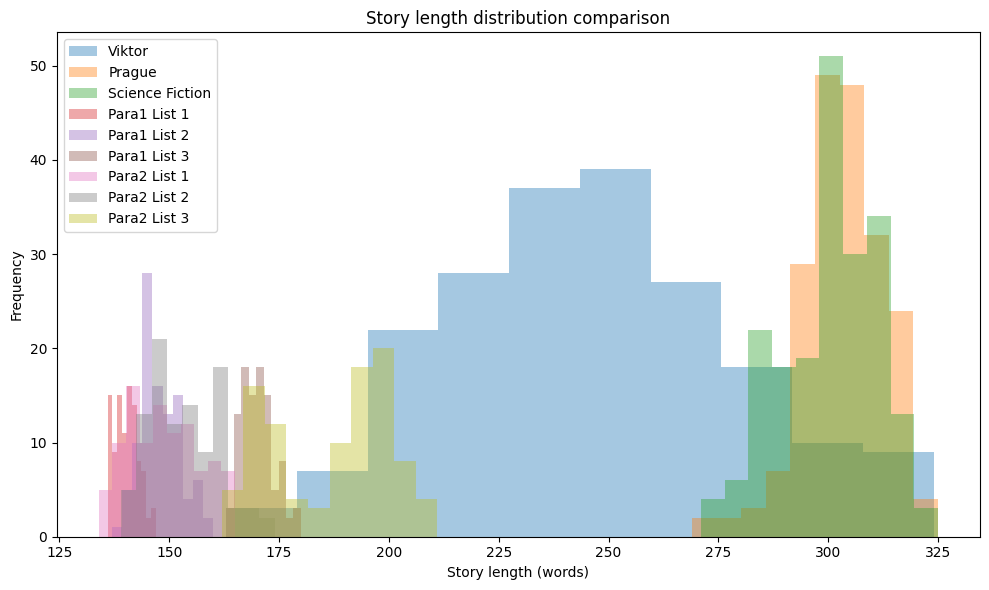

In [53]:
plt.figure(figsize=(10, 6))
bins = 10  # Adjust granularity

for lens, label, color in zip(batch_lengths, labels, colors):
    plt.hist(lens, bins=bins, alpha=0.4, label=label, color=color)

plt.xlabel("Story length (words)")
plt.ylabel("Frequency")
plt.title("Story length distribution comparison")
plt.legend()
plt.tight_layout()
plt.show()
